# ISLR Chapter 8 - Tree Based Methods

## Lab Exercises 

JRouser and JLiu approach are quite similar for this chapter so we only show the combined version

* [Lab 8.3.1 Fitting Classification Trees](#lab_8.3.1)

* [Lab 8.3.2 Fitting Regression Trees](#lab_8.3.2)

* [Lab 8.3.3 Bagging and Random Forests](#lab_8.3.3)

* [Lab 8.3.4 Boosting](#lab_8.3.4)

## [Conceptual Exercises](#concept)

The sklearn library has a lot of useful tools for constructing classification and regression trees:

In [1]:
'''
references:
JWarmenhoven: https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/
collinprather: https://github.com/collinprather/ISLR-Python
Jliu: https://github.com/0liu/ISLR

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab14-py.html
'''

# Standard libraries
import time
import warnings

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from patsy import dmatrix

# scikit-learn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

# Visulization
from IPython.display import display
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
import pydotplus # had to install new packages using conda, for some reason pip did not work
import graphviz

<a id='lab_8.3.1'></a>
## Lab 8.3.1 Fitting Classification Trees

In [2]:
carseats = pd.read_csv('Carseats.csv')
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [3]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


Converting Sales to a binary variable:

In [4]:
# Coding qualitative variables
carseats['High'] = (carseats.Sales > 8).astype('int')
carseats['ShelveLoc'] = carseats.ShelveLoc.map({'Bad':0, 'Good':1, 'Medium':2}) # convert categorical to numbers
carseats['Urban'] = (carseats.Urban == 'Yes').astype('int') # convert yes/no to 1/0
carseats['US'] = (carseats.US == 'Yes').astype('int') # convert yes/no to 1/0
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


Start by using classification trees to analyze the Carseats data set. Unfortunately, manual pruning is not implemented in sklearn: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the max_depth parameter:

In [5]:
# Decision tree classification, on the whole data set.
# Trying to predict Sales figure
# Use max_depth to limit tree size, since manual pruning is not implemented in scikit-learn.

X = carseats.drop(['Sales', 'High'], axis=1)
y = carseats['High']

tree = DecisionTreeClassifier(max_depth=6) # max tree depth
tree.fit(X, y)
score = tree.score(X, y)

print("Training error rate = ", 1-score)
print("Tree node size =", tree.tree_.node_count)

Training error rate =  0.08250000000000002
Tree node size = 65


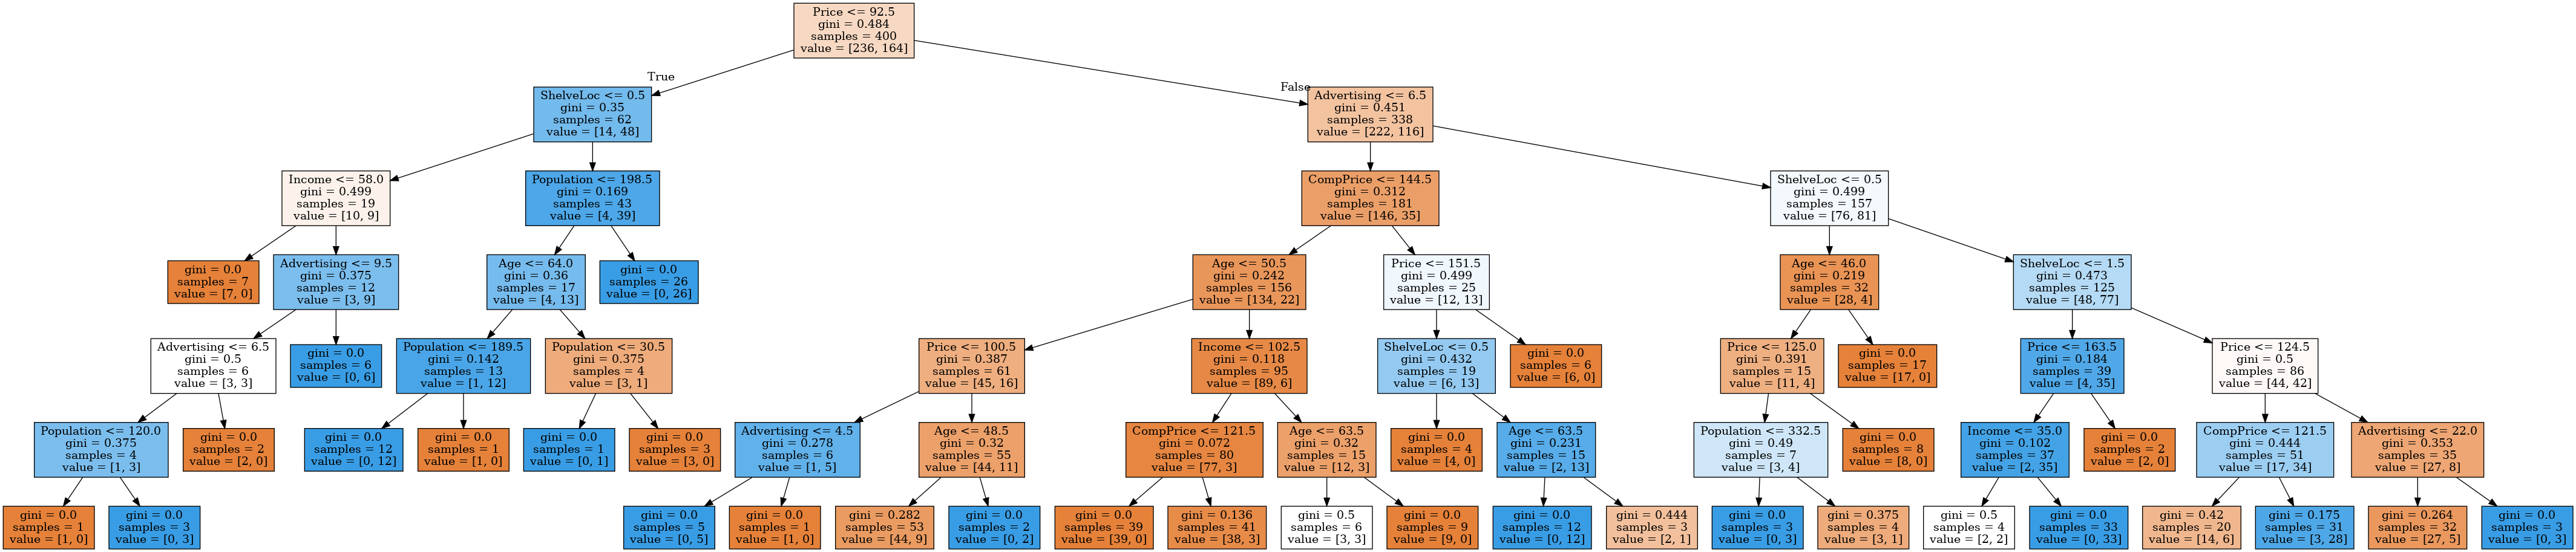

In [6]:
# Visualization
dot_data = export_graphviz(tree, out_file=None, feature_names=X.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png(), width=2000)

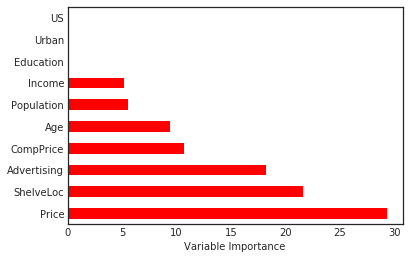

In [7]:
# Feature Importance
Importance = pd.DataFrame({'Importance':tree.feature_importances_*100}, index=X.columns)

# Plot importance sorted in descending order 
Importance.sort_values('Importance', axis=0, ascending=False).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The most important indicator of High sales appears to be Price.

In [8]:
# Decision tree classification, on training set only.
# Use max_depth to limit tree size, since manual pruning is not implemented in scikit-learn.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)

tree = DecisionTreeClassifier(max_depth=6)

tree.fit(X_train, y_train)
score = tree.score(X_train, y_train)

print("Training error rate = ", 1-score)
print("Tree node size =", tree.tree_.node_count)

Training error rate =  0.015000000000000013
Tree node size = 61


In [9]:
# Prediction
y_pred = tree.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print('Confusion matrix:\n', cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77       118
           1       0.67      0.76      0.71        82

    accuracy                           0.74       200
   macro avg       0.74      0.75      0.74       200
weighted avg       0.75      0.74      0.75       200

Confusion matrix:
      No  Yes
No   87   20
Yes  31   62


We are making correct predictions for around 74% of the test data set.

<a id='lab_8.3.2'></a>
## Lab 8.3.2 Fitting Regression Trees

Let's try fitting a regression tree to the Boston data set. First, we create a training set, and fit the tree to the training data using medv (median home value) as our response:

In [10]:
boston = pd.read_csv('Boston.csv', index_col = 0)
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
505,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [11]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


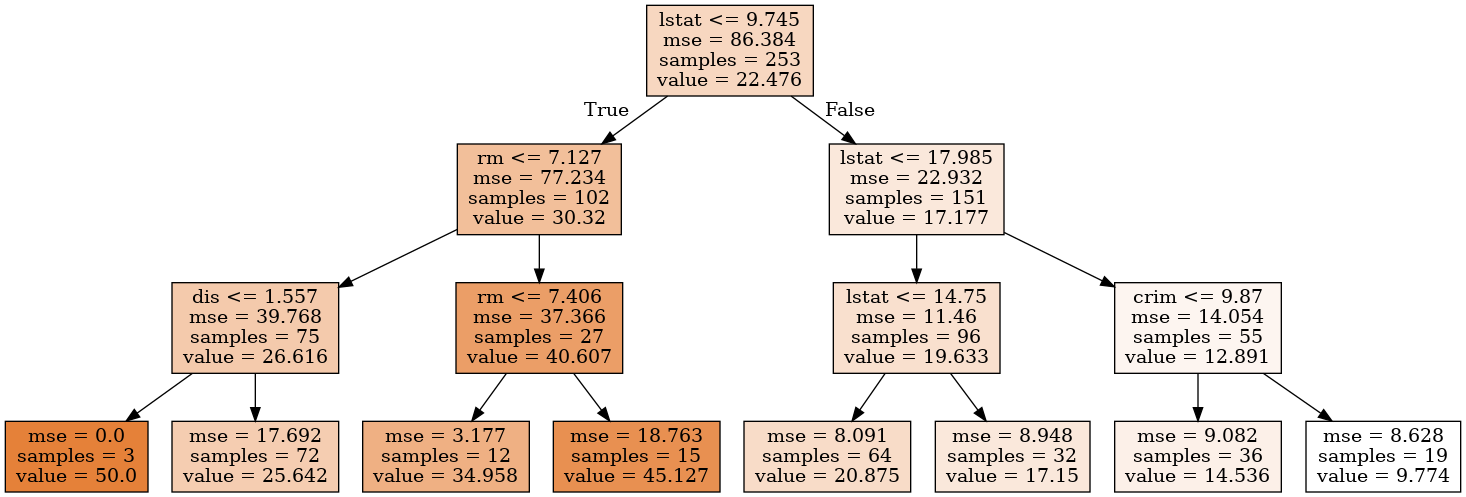

In [25]:
# Try to predict median house price in Boston, medv
# Tree regression and prediction
X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=12)
tree_regr = DecisionTreeRegressor(max_depth=3)  # No pruning in scikit-learn
tree_regr.fit(X_train, y_train)

# Visualization
dot_data = export_graphviz(tree_regr, out_file=None, feature_names=X.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png(), width=2000)

The variable lstat measures the percentage of individuals with lower socioeconomic status. 
The tree indicates that lower values of lstat correspond to more expensive houses. 
The tree predicts a median house price of $45,127 for larger homes (rm>7.406) in suburbs in which residents have high socioeconomic status (lstat<=9.745).

graphviz is a base library that visualizes tree but there is not an easy way to resize the image size unlike using pydotplus which is based on graphviz. 


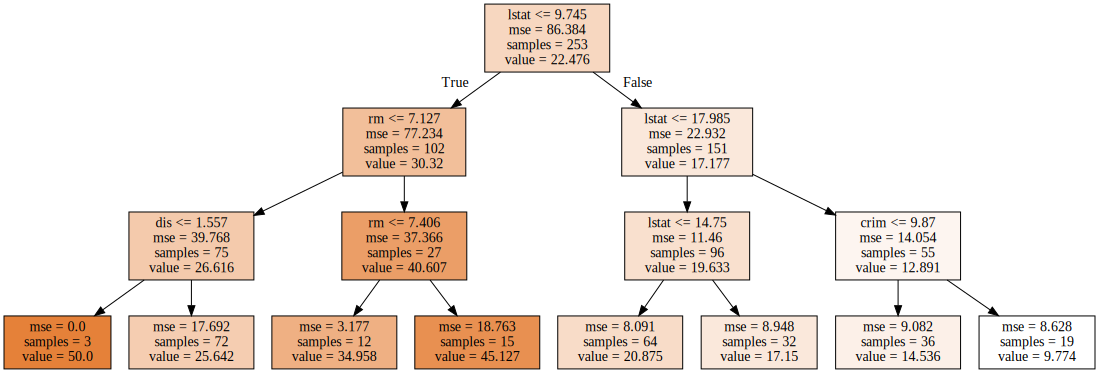

In [24]:
graphviz.Source(dot_data)

Now let's see how it does on the test data:

MSE =  22.42853422194836


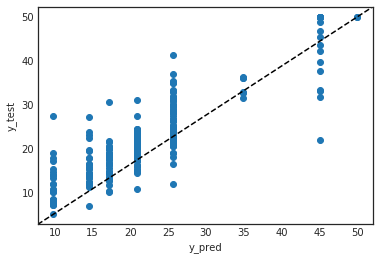

In [14]:
# Prediction
y_pred = tree_regr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

The test set MSE associated with the regression tree is 22.43. The square root of the MSE is therefore around 4.74, indicating that this model leads to test predictions that are within around $4,740 of the true median home value for the suburb.

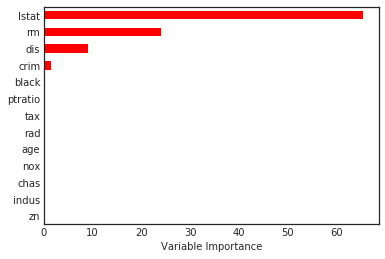

In [15]:
# Feature Importance
importance = pd.DataFrame({'Importance':tree_regr.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)

importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

<a id='lab_8.3.3'></a>
## Lab 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may depend on the version of python and the version of the RandomForestRegressor package installed. Recall that bagging is simply a special case of a random forest with  m=p . Therefore, the RandomForestRegressor() function can be used to perform both random forests and bagging. Let's start with bagging:

In [16]:
# Random forest with m = 13 features, maximum features selected during each step
rf13 = RandomForestRegressor(max_features=13, random_state=12)
rf13.fit(X_train, y_train)

y_pred = rf13.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  12.778267462450595


The argument max_features = 13 indicates that all 13 predictors should be considered for each split of the tree -- in other words, that bagging should be done. How well does this bagged model perform on the test set?

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

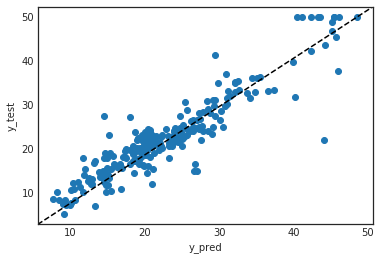

In [17]:
plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

We can grow a random forest in exactly the same way, except that we'll use a smaller value of the max_features argument. Here we'll use max_features = 6:

In [18]:
# Random forest with m =6 features
rf6 = RandomForestRegressor(max_features=6, random_state=12)
rf6.fit(X_train, y_train)
y_pred = rf6.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  10.944408636363638


The test set MSE is even lower; this indicates that random forests yielded an improvement over bagging in this case.

Using the feature_importances_ attribute of the RandomForestRegressor, we can view the importance of each variable:

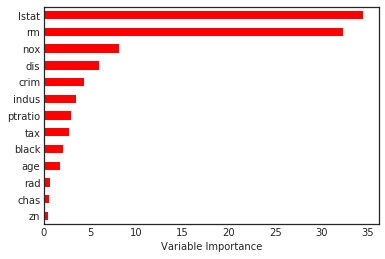

In [19]:
# Feature importance
importance = pd.DataFrame({'Importance':rf6.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)

importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random forest, the wealth level of the community (lstat) and the house size (rm) are by far the two most important variables.

<a id='lab_8.3.4'></a>
## Lab 8.3.4 Boosting

Now we'll use the GradientBoostingRegressor package to fit **boosted regression trees** to the Boston data set. The argument n_estimators = 500 indicates that we want 500 trees, and the option interaction.depth = 3 limits the depth of each tree, and learning_rate as the shrinkage parameter $\lambda$:

In [20]:
gbr = GradientBoostingRegressor(n_estimators=500, 
                                learning_rate=0.01, 
                                max_depth = 3, # default is 3
                                random_state=12) # number of trees set to 500 to 
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  11.974388911917202


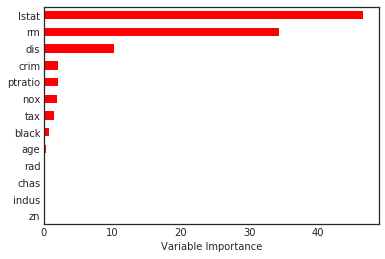

In [21]:
# Feature importance
importance = pd.DataFrame({'Importance':gbr.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)

importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We see that lstat and rm are again the most important variables by far

The test MSE obtained is similar to the test MSE for random forests and superior to that for bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda$ = 0.2.

In [22]:
gbr = GradientBoostingRegressor(n_estimators=500, 
                                learning_rate=0.2, 
                                max_depth = 3, # default is 3
                                random_state=12) # number of trees set to 500 
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  11.227071995957388


In this case, using  $\lambda$=0.2  leads to a slightly lower test MSE than  $\lambda$=0.01

<a id ='concept'></a>
## Conceptual Exercises

Taken from: https://blog.princehonest.com/stat-learning/

1) Draw an example if a partition of two-dimensional feature space that could result from recursive binary splitting

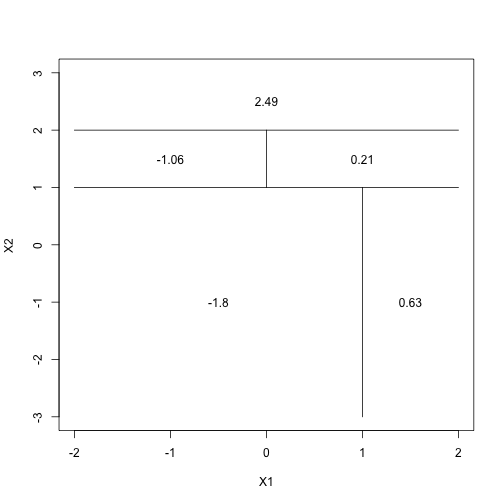

2) Boosting using depth = 1 trees (or stumps) leads to an additivie model. Explain why.

5) Suppose we have 10 bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each boostrapped sample and for a specific value of X, produce 10 estimates of P(Class is Red|X): 

p = c(0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75)

### Majority approach

sum(p >= 0.5) > sum(p < 0.5)

- True
 
The number of red predictions is greater than the number of green predictions using a 50% threshold, thus RED.
 
### Average approach
 
mean(p)
 
- 0.45 
 
The average of the probabilities is less than 50% threshold, thus GREEN.

**6) Provide a detailed explanation of the algorithm that is used to fit a regression tree.**

Refer to section 8.1.1 Algorithm 8.1.

1) Use recursive binary splitting to grow a large tree on the training data, stopping only when each tereminal node has fewere than some minimum number of observations.

2) Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.

3) Use K-fold cross validation to choos $\alpha$. That is, divide the training observations into K folds. For each k = 1,...,K:
   - Repeat Steps 1 and 2 on all but the kth fold of the training data.
   
   - Evaluate the mean squared prediction error on the data in the left-out kth fold, as a function of $\alpha$
   
     Average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.
     
4) Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.